# Ambiente para download do dataset

In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json

!kaggle datasets download -d brsdincer/vehicle-detection-image-set
!unzip /content/vehicle-detection-image-set.zip -d /content/kaggle

!pip install keras-tuner --upgrade

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/kaggle/data/vehicles/4452.png  
  inflating: /content/kaggle/data/vehicles/4453.png  
  inflating: /content/kaggle/data/vehicles/4454.png  
  inflating: /content/kaggle/data/vehicles/4455.png  
  inflating: /content/kaggle/data/vehicles/4456.png  
  inflating: /content/kaggle/data/vehicles/4457.png  
  inflating: /content/kaggle/data/vehicles/4458.png  
  inflating: /content/kaggle/data/vehicles/4459.png  
  inflating: /content/kaggle/data/vehicles/446.png  
  inflating: /content/kaggle/data/vehicles/4460.png  
  inflating: /content/kaggle/data/vehicles/4461.png  
  inflating: /content/kaggle/data/vehicles/4462.png  
  inflating: /content/kaggle/data/vehicles/4463.png  
  inflating: /content/kaggle/data/vehicles/4464.png  
  inflating: /content/kaggle/data/vehicles/4465.png  
  inflating: /content/kaggle/data/vehicles/4466.png  
  inflating: /content/kaggle/data/vehicles/4467.png  
  inflating: /content/ka

In [6]:
from tensorflow import keras
import tensorflow as tf
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Activation, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import cv2
import os
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from tensorflow.keras.preprocessing import image

# Analise exploratória dos dados


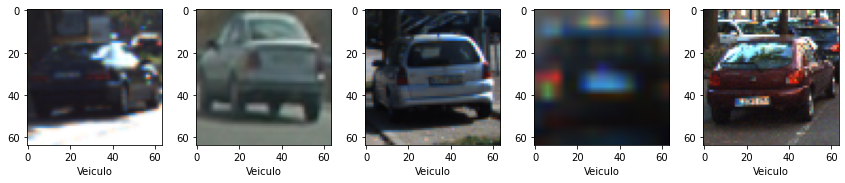

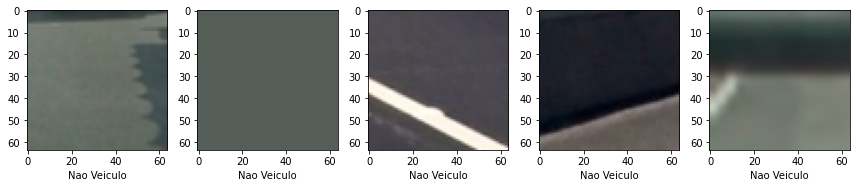

In [7]:
vehicle = os.listdir('/content/kaggle/data/vehicles')
non_vehicle = os.listdir('/content/kaggle/data/non-vehicles')



vehicle_img = np.random.choice(vehicle,5)
nonvehicle_img = np.random.choice(non_vehicle,5)

plt.figure(figsize=(12,9))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = cv2.imread('/content/kaggle/data/vehicles/'+vehicle_img[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel("Veiculo")
    #plt.axis("off")
    plt.tight_layout()
    plt.imshow(img)
plt.show()


plt.figure(figsize=(12,9)) 
for i in range(5):
    plt.subplot(1,5,i+1)
    img = cv2.imread('/content/kaggle/data/non-vehicles/'+nonvehicle_img[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel("Nao Veiculo")
    #plt.axis("off")
    plt.imshow(img)
plt.tight_layout()
plt.show()

# Criação do banco de dados

In [8]:
import tqdm
from tensorflow.keras.preprocessing import image

train = []
label = []

for i in tqdm.tqdm(vehicle):
    img = cv2.imread('/content/kaggle/data/vehicles/'+ i)
    img = cv2.resize(img,(64,64))
    train.append(img)
    label.append("Vehicle")
    
for i in tqdm.tqdm(non_vehicle):
    img = cv2.imread('/content/kaggle/data/non-vehicles/'+ i)
    img = cv2.resize(img,(64,64))
    train.append(img)
    label.append("Non Vehicle")

train = np.array(train)
label = np.array(label)
train.shape,label.shape

100%|██████████| 8968/8968 [00:02<00:00, 4102.18it/s]


((17760, 64, 64, 3), (17760,))

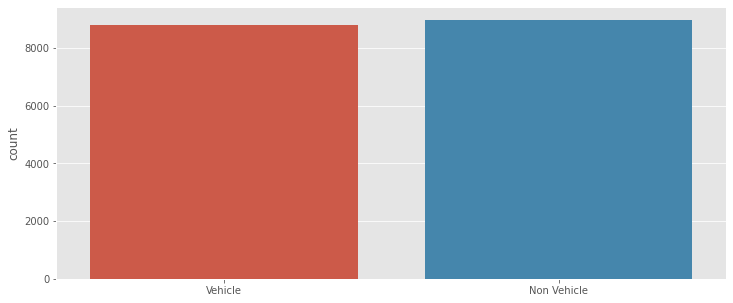

In [9]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(12,5))
sns.countplot(x = label)
plt.show()

# Pre-Processamento

In [10]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# Encoders - LabelEncoder
le = LabelEncoder()
label= le.fit_transform(label)

label = to_categorical(label)
print("Labels: ", np.unique(label))
print(label.shape)
train, label = shuffle(train, label)

# Separar o dataser
x_train,x_test,y_train,y_test = train_test_split(train,label,test_size=0.2,random_state = 42)

Labels:  [0. 1.]
(17760, 2)


# Modelo Deep Learning

In [11]:
model = Sequential()

model.add(Conv2D(32, 3,padding="same", activation="relu", input_shape=(64,64,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

# Otimizador e Loss-Function

In [12]:
opt = Adam(lr=0.001)
model.compile(optimizer = opt , loss = "binary_crossentropy", metrics = ['accuracy'])

callback =  [
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
      tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
      tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]

history = model.fit(
    x_train,y_train,
    epochs = 10 ,
    batch_size=10,
    validation_data = (x_test,y_test),
    callbacks=[callback], 
    verbose=2,
    shuffle=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
1421/1421 - 26s - loss: 0.3763 - accuracy: 0.9120 - val_loss: 0.1519 - val_accuracy: 0.9367 - 26s/epoch - 18ms/step
Epoch 2/10
1421/1421 - 10s - loss: 0.0997 - accuracy: 0.9666 - val_loss: 0.0683 - val_accuracy: 0.9772 - 10s/epoch - 7ms/step
Epoch 3/10
1421/1421 - 10s - loss: 0.0752 - accuracy: 0.9761 - val_loss: 0.0537 - val_accuracy: 0.9800 - 10s/epoch - 7ms/step
Epoch 4/10
1421/1421 - 10s - loss: 0.0523 - accuracy: 0.9811 - val_loss: 0.0499 - val_accuracy: 0.9876 - 10s/epoch - 7ms/step
Epoch 5/10
1421/1421 - 10s - loss: 0.0545 - accuracy: 0.9835 - val_loss: 0.0291 - val_accuracy: 0.9924 - 10s/epoch - 7ms/step
Epoch 6/10
1421/1421 - 10s - loss: 0.0473 - accuracy: 0.9872 - val_loss: 0.0829 - val_accuracy: 0.9733 - 10s/epoch - 7ms/step
Epoch 7/10
1421/1421 - 10s - loss: 0.0720 - accuracy: 0.9787 - val_loss: 0.0614 - val_accuracy: 0.9828 - 10s/epoch - 7ms/step
Epoch 8/10
1421/1421 - 10s - loss: 0.0449 - accuracy: 0.9868 - val_loss: 0.0515 - val_accuracy: 0.9865 - 10s/epoch - 

# Validação do modelo

In [13]:
model.evaluate(x_test,y_test)

111/111 [==============================] - 1s 6ms/step - loss: 0.0672 - accuracy: 0.9848


[0.06719078123569489, 0.9847972989082336]

In [14]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
y_pred[:15]

array([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1])

In [15]:
y_test = np.argmax(y_test,axis=1)
y_test[:15]


array([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1])

In [16]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1823
           1       0.98      0.99      0.98      1729

    accuracy                           0.98      3552
   macro avg       0.98      0.98      0.98      3552
weighted avg       0.98      0.98      0.98      3552



(<Figure size 576x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2f1bc50f10>)

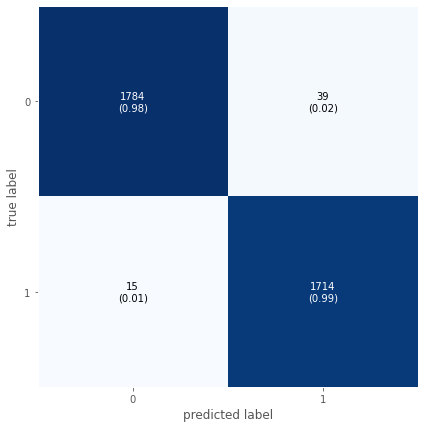

In [17]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),
                     show_normed = True)

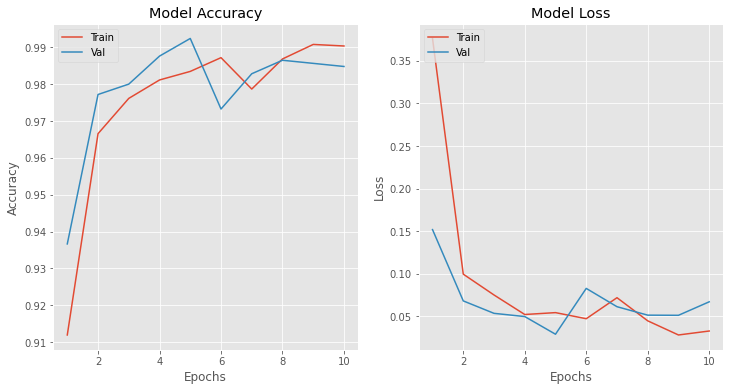

In [18]:
plt.figure(figsize = (12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history.history['accuracy'])
plt.plot(epochs,history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Val'],loc ='upper left')

plt.subplot(1,2,2)
plt.plot(epochs,history.history['loss'])
plt.plot(epochs,history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Val'],loc ='upper left')
plt.show()

# Predição das amostras

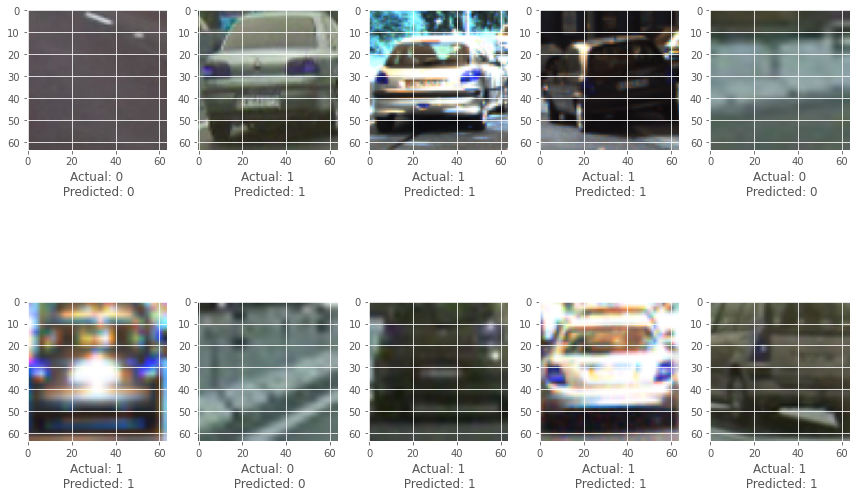

In [19]:
plt.figure(figsize=(12,9))
for i in range(10):
    sample_idx = np.random.choice(range(len(x_test)))
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[sample_idx])
    plt.xlabel(f"Actual: {y_test[sample_idx]}\n Predicted: {y_pred[sample_idx]}")
    
    
plt.tight_layout()
plt.show()